In [1]:
# !pip install python-dotenv

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')

In [5]:
from langchain_groq import ChatGroq

llm = ChatGroq(groq_api_key=os.environ["GROQ_API_KEY"], model_name="Gemma2-9B-IT")

In [7]:
def multiply(a: int, b: int) -> int:
    """ Multiply a & b
    Args: 
        a: first int
        b: second int
    """
    return a*b

def add(a: int, b: int) -> int:
    """ Add a & b
    Args:
        a: first int
        b: second int
    """
    return a+b

def divide(a: int, b: int) -> float:
    """ Divide a & b
    Args: 
        a: first int
        b: second int
    """
    return a/b

In [18]:
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

In [31]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

##System messgae
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arthimetic operations on a set of inputs")

## Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state['messages'])]}

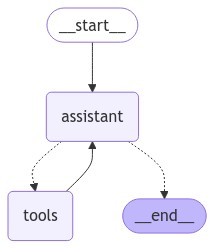

In [32]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

## Graph
builder = StateGraph(MessagesState)

## Define Nodes:
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

## Define edges:
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

## Display
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [21]:
messages = [HumanMessage(content="Add 3 and 4, then multiply by 5 and finally divide by 2")]
messages = react_graph.invoke({'messages': messages})

In [22]:
messages

{'messages': [HumanMessage(content='Add 3 and 4, then multiply by 5 and finally divide by 2', id='56bbf0f3-eb15-4ea4-b196-5ed3ac322c85'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q6y2', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1305, 'total_tokens': 1390, 'completion_time': 0.154545455, 'prompt_time': 0.042405804, 'queue_time': 0.0029644160000000044, 'total_time': 0.196951259}, 'model_name': 'Gemma2-9B-IT', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0a1976dd-c7c1-4ada-b2f2-6679c241aa7c-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_q6y2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1305, 'output_tokens': 85, 'total_tokens': 1390}),
  ToolMessage(content='7', name='add', id='34199dda-7b54-42de-a6a8-13dd1608bd5f', tool_call_id='call_q6y2'),
  AIMessage(cont

In [30]:
messages['messages'][4]

ToolMessage(content='35', name='multiply', id='28bef03e-ede6-4347-b7ff-50c173826576', tool_call_id='call_z76t')

In [23]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4, then multiply by 5 and finally divide by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_q6y2)
 Call ID: call_q6y2
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_z76t)
 Call ID: call_z76t
  Args:
    a: 7
    b: 5
================================= Tool Message =================================
Name: multiply

35
================================== Ai Message ==================================
Tool Calls:
  divide (call_azzw)
 Call ID: call_azzw
  Args:
    a: 35
    b: 2
================================= Tool Message =================================
Name: divide

17.5
================================== Ai Message ==================================

17.5


## For Memory

In [33]:
messages = [HumanMessage(content="Add  3 and 4")]
messages = react_graph.invoke({'messages': messages})

In [35]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add  3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_nj04)
 Call ID: call_nj04
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7


In [38]:
messages = [HumanMessage(content="Multiply by 2")]
messages = react_graph.invoke({'messages': messages})

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n\t"tool_call": {\n\t\t"id": "pending",\n\t\t"type": "function",\n\t\t"function": {\n\t\t\t"name": "multiply"\n\t\t},\n\t\t"parameters": {\n\t\t\t"a": 2,\n\t\t\t"b": "inputs"\n\t\t}\n\t}\n}\n</tool-use>'}}

In [ ]:
for m in messages['messages']:
    m.pretty_print()

In [41]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [42]:
config = {"configurable": {"thread_id": "1"}}
messages = HumanMessage(content="Add 3 & 4")
messages = react_graph_memory.invoke({'messages': messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 & 4
================================== Ai Message ==================================
Tool Calls:
  add (call_ab35)
 Call ID: call_ab35
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7


In [44]:
messages = HumanMessage(content="Multiply that by 2")
messages = react_graph_memory.invoke({'messages': messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 & 4
================================== Ai Message ==================================
Tool Calls:
  add (call_ab35)
 Call ID: call_ab35
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7
================================ Human Message =================================

Multiply that by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_y9f6)
 Call ID: call_y9f6
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

14


## Deployment

In [45]:
from langgraph_sdk import get_client

In [46]:
URL = "http://localhost:57270"
client = get_client(url=URL)
assistants = await client.assistants.search()
assistants

[{'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'created_at': '2024-09-14T03:18:19.241898+00:00',
  'updated_at': '2024-09-14T03:18:19.241898+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}},
 {'assistant_id': '228f9934-0cdd-5383-92c8-ee8422522cc2',
  'graph_id': 'router',
  'created_at': '2024-09-14T03:18:19.196498+00:00',
  'updated_at': '2024-09-14T03:18:19.196498+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}},
 {'assistant_id': '28d99cab-ad6c-5342-aee5-400bd8dc9b8b',
  'graph_id': 'simple_graph',
  'created_at': '2024-09-14T03:18:18.871060+00:00',
  'updated_at': '2024-09-14T03:18:18.871060+00:00',
  'config': {},
  'metadata': {'created_by': 'system'}}]

In [47]:
agent = assistants[0]

In [48]:
agent

{'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
 'graph_id': 'agent',
 'created_at': '2024-09-14T03:18:19.241898+00:00',
 'updated_at': '2024-09-14T03:18:19.241898+00:00',
 'config': {},
 'metadata': {'created_by': 'system'}}

In [49]:
thread = await client.threads.create()

In [51]:
from langchain_core.messages import HumanMessage

#Input 
input = {"messages": [HumanMessage(content= "Multiply 3 and 2")]}

## Stream
async for chunk in client.runs.stream(
    thread['thread_id'],
    "agent",
    input=input,
    stream_mode = "values"
):
    if chunk.data and chunk.event!= "metadata":
        print(chunk.data['messages'][-1])


{'content': 'Multiply 3 and 2', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '024c926e-fa4d-4ddb-8404-7f07bc35cabb', 'example': False}
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_3jb3', 'function': {'arguments': '{"a":3,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls'}, 'type': 'ai', 'name': None, 'id': 'run-73e6a1a6-6b08-4b66-a567-0c90ff89c49a', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 2}, 'id': 'call_3jb3', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 1279, 'output_tokens': 85, 'total_tokens': 1364}}
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': 'ea5e249e-8f3c-4594-90a2-5696846478bb', 'tool_call_id': 'call_3jb3', 'artifact': None, 'status': 'success'}
{'c